<a href="https://colab.research.google.com/github/leonardobove/handwritten_digit_recognition/blob/main/python/digital_twin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python quantized model of a MLP neural network

In [33]:
import numpy as np
import matplotlib.pyplot as plt
#import torchvision
import tensorflow as tf

In [34]:
# **Average Pooling Function**
def average_pooling(matrix, pool_size=2):
    """
    Apply average pooling on input matrix, with given pool size
    """
    new_h, new_w = matrix.shape[0] // pool_size, matrix.shape[1] // pool_size
    pooled_matrix = np.zeros((new_h, new_w), dtype=np.int8)

    for i in range(new_h):
        for j in range(new_w):
            idx_x, idx_y = i * pool_size, j * pool_size
            block = matrix[idx_x:idx_x + pool_size, idx_y:idx_y + pool_size]
            pooled_matrix[i, j] = np.sum(block) // pool_size**2  # Integer division for mean

    return pooled_matrix

In [35]:
# **Forward Pass for a Single Layer**
def layer_forward(inputs, weights, biases, verbose=False):
    """
    Perform a forward pass through a single layer:
    - Multiply-Accumulate (MAC) operation.
    - Apply ReLU.
    """
    # Compute MAC
    mac = np.dot(inputs.astype(np.int32), weights.T.astype(np.int32)) + biases.astype(np.int32)
    if verbose:
      print(f"Dense out:\n{mac}")

    # Apply ReLU
    return np.maximum(mac, 0)

In [36]:
# **Decision Function**
def decision(outputs):
    """
    Return the index of the maximum output (final prediction).
    """
    return np.argmax(outputs)

In [37]:
weights_HL = np.array([
  [-4, 9, 7, -3, 10, 8, 2, 6, 11, 5, -3, 11, 3, -3, -7, 7, 2, 13, 4, 2, -18, -29, -48, -41, -62, -5, -12, -4, -1, -25, -2, -3, 8, -3, -9, -13, -3, -16, -12, 9, -2, -4, 21, 4, 30, 13, 11, 20, 1, 3, 11, 14, 14, 28, 2, -25, 57, 27, 21, 16, 18, 20, 34, 42, 19, 17, 21, 38, -18, 9, 62, 4, 14, 22, 17, 36, -14, -27, 5, 0, -1, -13, -24, 39, 41, -4, 20, 26, 11, -58, -120, -43, -9, -8, -22, -26, -9, 48, 25, -24, -33, -41, -85, -70, -16, -32, -32, -26, -23, -37, -49, 37, -3, -29, -57, -91, -71, 9, 21, -16, -34, -35, -50, -31, -10, 48, 19, -26, -21, -19, 8, 31, 44, 5, -15, -18, -10, -2, 24, 64, 28, 24, 0, 6, 1, 24, 35, 42, 37, 31, 18, 16, 18, 50, -14, 4, 4, 6, 13, 15, 25, 32, 28, 47, 31, 45, 50, 25, -8, -31, -3, 14, 1, -6, 23, 29, 15, 38, 9, 26, 60, 20, -8, 10, -32, 25, 61, 6, 0, 18, -7, 28, -10, -12, 6, 6],
  [-5, 9, -2, 35, 53, 51, 47, -24, 58, 65, 46, 14, 5, 5, -3, 25, 1, 13, 40, 38, 23, 17, 1, -16, -2, 37, 11, 12, -4, -36, 5, 12, 0, 3, 20, 6, 17, -6, -4, -22, -29, 5, -44, -18, -18, -16, -15, 2, 3, 24, 26, -6, -6, 3, -8, -20, -7, -10, 0, -13, -3, 4, -12, -10, 1, 26, 10, 23, -1, -29, -15, -25, 21, 6, -3, -10, -6, -40, -28, 26, 39, 40, -2, -49, -11, 2, 28, 31, 6, -7, -27, -27, -21, 15, 31, 68, 75, -37, -26, -44, -5, 45, 32, 20, 11, 8, 10, 50, 51, 36, 35, 51, -22, -54, 6, 44, 65, 56, 17, 24, 22, 14, 18, 10, 17, 30, -3, -48, -16, 18, 29, 39, 8, 23, 12, -2, 2, -9, -18, 13, 19, 6, -7, -5, 13, 11, 6, 6, -14, -13, -22, -20, -26, 17, -15, 4, -25, 12, 12, 10, 10, -9, -24, -34, -12, 11, -5, -48, 3, -44, -2, -5, -9, -1, -22, -16, -56, -28, -14, 1, -1, -4, -3, 19, 61, 60, 56, 21, 11, 29, -44, 1, 26, -3, 25, 3],
  [11, 7, 6, -11, 5, -10, 8, -40, -43, -14, -27, -14, -12, -6, 11, -6, 27, -5, -11, -9, -7, -9, 18, 53, 52, 49, 0, 28, 4, -16, -21, -10, -21, -16, -8, -3, 23, 25, 28, 38, 51, 20, 11, -17, -9, -3, 3, 1, -2, 24, 27, 36, 16, 9, 54, 24, -34, -23, -45, -3, 3, 9, 12, -19, 1, 15, 27, 10, 56, 40, -33, -23, -23, -12, -3, 9, 23, -4, 5, -2, -16, -22, 59, 58, 5, -8, 2, -16, -21, 25, 21, 20, 20, 13, -15, -44, -67, -21, 30, -12, -6, -22, -15, 19, -1, 4, 25, 24, 2, -11, -44, -73, 1, -20, -8, 6, -23, -16, -12, -3, 21, 18, 7, -27, -47, -70, -12, 16, 15, 22, 6, 13, 1, 9, 6, -16, -25, -39, -40, -39, 13, -35, -4, -7, 0, 4, 9, 16, -1, -38, -42, -35, -22, -31, -4, 5, -23, -19, 1, 19, 29, 20, -9, -34, -48, -23, 2, 14, 2, 64, 72, 26, 42, 54, 50, 41, 9, -4, -7, 8, -14, -23, -2, -6, 26, -8, -11, 41, 35, -10, -5, -15, 2, 22, -1, 2],
  [-7, 4, -1, -20, -31, -52, -61, 2, 32, -40, -40, -23, -8, 8, 5, 11, -29, -6, -47, -31, 11, 28, 36, 27, 37, 9, -41, -11, 0, -24, -12, 29, 34, 41, 9, 6, 28, -2, 20, 20, -9, -14, -27, -35, 8, 24, 30, 2, -39, -66, -2, 4, -10, 8, 3, 8, -28, -2, 12, 8, 18, -2, -34, -42, 35, 9, 15, 2, 24, 11, -14, -14, 6, -9, 27, 14, -54, -45, 7, -5, -9, -25, -24, 19, 6, -9, 5, -2, -10, 29, 19, -22, -17, 9, 13, -12, -32, -24, -16, -2, 22, 24, 8, -8, 27, 21, 12, 3, -16, -8, -48, 9, -15, 22, 21, 4, -10, -19, 17, 9, -8, -26, -22, -39, -57, 25, -17, 22, 13, -1, -25, -7, 39, -1, -23, -20, -12, -10, -3, 45, -18, -4, -17, -28, -43, 25, 7, -3, 13, 6, 18, 18, 17, 20, -1, 14, -24, -49, -38, -14, 10, 23, 22, 17, 34, 34, 11, 16, 0, 15, -24, -43, -43, -20, 11, 42, 33, 15, -14, -2, 9, 4, 6, -9, -30, -28, -43, -46, -46, -58, -44, -26, -32, -14, -6, 6],
  [-6, 1, 10, 17, 5, 8, 13, 25, 53, 27, 45, 14, -4, -6, 12, 9, 10, 38, 60, 77, 53, 34, 6, -12, -29, -9, 16, -19, -8, -2, 43, 21, 22, -10, -7, 2, 17, 11, 0, -5, -9, 5, 25, -1, 16, -14, -35, -28, -48, 8, 14, -16, -21, -3, 14, -9, 36, 36, 32, -2, -6, -14, -26, 9, 20, -11, -3, -15, -45, -12, 38, 19, 10, 10, 11, -33, -39, 32, 5, -10, 11, 0, -22, -34, -19, -34, -23, -27, -27, -23, 42, 29, -16, -29, 0, -8, 88, 38, -19, -1, -20, -27, -10, 6, 60, 44, -14, -20, -30, 0, 51, 65, 11, 45, -3, 14, 29, 42, 34, 19, 11, 6, -10, 20, 57, 50, -21, 13, 11, 17, 34, 10, -6, 10, 30, 25, 21, 43, 36, 57, -19, 32, 12, 23, 14, -20, -11, 7, 26, 23, 30, -2, -36, 35, 15, 53, 28, 10, 1, 3, -8, -3, -9, -2, 5, -37, -54, -15, 1, -39, -33, -23, -2, -3, -21, -30, -32, -27, -20, -51, -1, 8, -5, -13, -38, -38, -58, -62, -99, -117, -100, -54, -93, -50, -13, -7],
  [-10, -10, 7, 37, 32, 65, 49, 4, 30, 58, 52, 17, 6, -10, 2, 15, 37, 12, -10, 13, 7, 41, 23, 28, 20, 34, -10, 2, 11, -52, -34, -13, 19, -15, -13, 2, 2, 14, 5, -16, -15, 26, -15, -49, -36, -7, 5, 2, -6, -12, -13, -21, 6, 10, 4, -9, -26, -29, -11, -5, 20, 5, -26, -22, -26, -5, 7, -19, -30, -18, -17, -54, -41, 10, 25, 8, -29, -38, -20, -7, 13, 8, -43, -68, -13, -64, -37, 15, 23, 29, -13, -9, 13, 13, 23, 32, -17, -82, 1, -39, -24, -5, -2, 18, 15, 10, 16, 4, -19, 3, -20, -48, -25, -41, -65, -48, -28, 22, 24, 21, 21, -11, -15, -13, 7, -61, -33, -47, -75, -84, -22, 51, 47, 3, 0, 4, -22, -2, -4, -41, 15, -53, -69, -82, -29, 27, 29, 33, 18, 0, -14, -1, -18, 6, -20, -19, -39, -48, -32, -29, 13, 23, 21, 11, 5, -8, -32, -15, 4, -36, -21, -45, -46, -14, -25, 7, 2, 8, -2, 4, -19, -28, -7, 11, 16, 28, 14, -6, 6, -12, -5, -1, -27, -29, -1, -1],
  [-1, -11, 14, 7, 25, 31, 32, -1, -33, 48, 52, 15, 5, 8, 8, 31, 11, 28, -19, -18, -46, -46, -15, 12, 30, 21, -11, 3, 0, 5, 14, -21, -19, -27, -48, -42, -33, -25, -23, 23, -14, -25, -50, -21, 5, -36, -11, -28, -27, -2, 3, -7, -3, 33, 10, 1, -43, -45, -28, -35, -19, -34, -3, 4, 11, -21, -12, -26, -31, -38, 16, -49, -64, -41, -13, -11, 26, 13, 4, -32, -33, -30, -64, -50, -9, -43, -89, -11, 13, 41, 68, 32, 16, 11, -3, -24, -64, -64, -5, 0, -46, -46, 25, 58, 41, 13, 31, 14, -6, -54, -68, -66, 16, -34, -40, -48, 3, 33, 9, -3, 1, 0, -12, -39, -63, -52, -14, -39, -49, -34, -17, 1, 22, 5, -4, -15, -45, -37, -33, -9, 14, -14, -23, -31, -34, -18, -3, 3, -8, -21, -44, -24, -23, 12, 21, -36, 11, -4, 7, -10, -20, -20, -11, 13, -16, -11, -7, 34, -3, -31, 13, -1, 9, -12, -19, -7, 5, 23, 0, 34, 11, -6, -2, 17, 22, 12, -2, 0, -20, 18, 16, -37, -17, -34, 5, 1],
  [-2, 11, -6, -18, -14, -43, -35, -31, -45, -26, -24, -20, 0, 7, 12, 3, -3, -36, -61, -76, -67, -72, -57, -47, -54, -10, 16, 0, -1, -33, 33, 17, 10, -16, -9, -15, -21, -13, -9, 0, -2, 13, -22, 16, -3, 31, 19, -5, -17, -8, 8, -19, 9, -2, -24, -8, 32, 18, 22, 20, 1, 12, 5, 17, 5, 6, -29, -42, -22, 13, 56, 5, 23, 13, 18, 24, 14, 43, 44, 7, -49, -43, -42, -20, 61, 52, -4, 0, 17, 18, -11, 35, 44, 14, -24, -10, -46, -52, 3, 30, 3, -30, -24, -17, -1, 35, 37, 2, -35, -12, -31, -49, 8, -27, -63, -57, -52, -17, 20, 44, 15, -42, -32, -33, -16, -13, 32, -19, -94, -127, -41, 17, 45, 8, -42, -29, -19, -65, -10, 36, 8, -60, -105, -81, -22, 6, 7, 4, -2, -7, -17, -37, -14, 1, 6, -58, -50, -31, -16, -12, 8, 14, 13, 6, 7, -18, 14, 16, -4, -29, -26, -16, -52, -26, -19, 2, -12, 9, -1, -14, -22, 2, -12, 2, -14, 33, 44, -2, -11, -21, -8, 0, -11, -1, -6, -5],
  [2, -6, 2, -13, -15, -39, -47, -34, 24, -41, -35, -24, -8, -7, 5, 2, -10, 12, 24, 12, -27, -52, -39, -14, -2, 2, 32, -6, -4, -11, -18, 2, 9, 34, 30, 15, -17, -21, -7, -19, 16, 17, -14, 38, -16, 2, 20, 26, 38, 41, 21, 1, -7, -37, -15, -11, 3, 21, 24, 28, 24, 7, 18, 30, 31, 13, -13, -16, -7, 43, 1, 11, 45, 38, 4, 18, 5, 24, 18, 29, 12, -17, 20, 50, 22, 5, 4, -35, -30, -48, -36, 6, 23, 41, -7, -16, -5, 19, -19, 3, -69, -57, -54, -15, -6, 12, 25, 3, -46, -37, -41, 13, 5, 0, -69, -35, 18, 14, 3, 2, 7, -27, -11, -7, -5, 22, 21, -27, -67, 2, 26, 26, 8, 10, -3, -12, -10, -4, 12, 39, -9, -2, -27, 3, 9, -5, -4, -16, -14, -26, -4, -1, 11, -30, -15, -18, -30, 1, 4, 4, 2, -9, -13, -6, 3, 31, 10, -35, 2, -33, 14, 16, 9, -3, 7, 22, 18, 29, 17, -6, -3, -5, 7, 26, 26, 71, 105, 75, 72, 76, 64, 59, 77, 51, -7, 2],
  [-4, -8, 1, 3, 14, 3, -15, 5, 37, -42, -30, -4, -7, 8, -6, 7, -2, -18, 8, -10, 6, -11, 8, -20, -55, -46, -40, 14, -11, -24, -38, -51, -38, -15, -20, -24, -46, -96, -75, -64, -47, -10, 19, -23, -29, -10, -42, -29, -25, -19, -23, -28, -17, 8, -7, 11, 50, 10, -38, -33, -38, -8, 2, 23, 56, 59, 53, 52, 52, 15, 16, 20, -58, -4, -2, 11, 25, 19, 9, 18, 34, 59, 77, 64, -8, -13, -24, -12, 17, 29, 26, -9, -37, -58, -59, -43, 12, 71, 5, -39, 6, 0, 16, 27, 1, -4, 6, -12, -42, -51, -3, 29, -13, -14, 27, 28, 17, 15, -4, 3, 10, -12, -26, -23, 4, 28, 41, -48, 2, 22, 33, 18, 4, -1, -5, 11, -12, 13, 5, -20, 11, -39, -8, -15, -16, -19, -18, -25, -12, -2, 26, 1, 41, -2, -3, 11, 12, -4, -7, -9, -8, -18, -17, -22, -6, 30, 61, 6, 7, 13, -17, -68, -28, -1, -26, -8, 4, 8, 9, 20, 35, -11, -11, -2, -20, -47, -52, -3, 6, -4, 20, 6, 15, 21, -6, 3],
  [1, -1, -6, -19, -22, -15, -30, -5, -35, -25, -29, 2, 10, -3, 8, 6, -15, -51, -57, -64, -75, -45, -11, 21, -8, -12, -6, -3, 23, 24, 19, 8, -17, 0, 10, -3, 33, 29, 9, 5, 12, 3, 18, 1, 21, 11, 13, 2, 11, -5, 8, -17, -4, -7, -18, -5, -39, 37, 38, 27, 10, -9, -2, -15, 15, 16, 10, 12, -7, -15, -26, 44, -8, 6, -16, -17, -18, 1, 20, 9, -2, -2, -34, -29, -28, 2, -4, 20, 9, 36, 31, 31, 27, -12, -1, -5, -8, 3, 14, 15, -16, -8, 14, 19, 49, 57, 21, -13, 3, 9, -15, -7, 35, 3, -53, -44, -29, -43, 32, 44, 5, -32, -12, -2, 9, -35, -34, 6, -23, -28, -68, -59, -63, -27, -13, -14, -8, -3, -45, -6, 18, 20, 10, 5, -20, -27, -44, 4, -1, 1, 6, 12, -37, -9, -3, 48, 17, 15, 16, 10, 8, 17, 11, 9, 12, -1, -36, 22, -10, 40, 42, 44, 32, 27, 3, 8, -22, -15, -3, -25, -60, -2, -1, -12, 8, 25, 45, 16, -2, -7, 1, -48, -53, -22, -9, -6],
  [9, 9, -7, 7, -16, -23, -21, 19, 18, -19, -24, -11, 2, 3, 4, -18, -17, 4, 17, 38, 60, 67, 50, 5, -31, -30, -31, -21, -3, -11, 0, -14, 5, -12, -3, 39, 51, 45, 10, -10, -68, -50, 50, 32, -13, -24, -4, 5, 19, 16, 44, 46, 25, 3, -59, -39, 62, 17, -10, 12, 17, 6, -45, -42, 57, 48, 22, 11, -115, -69, 19, -22, -30, -37, -50, -48, -72, -63, 39, 38, 35, -3, -85, -43, 7, -40, -50, -26, -6, 1, -20, -30, -4, 14, -2, -31, -30, -14, 14, 14, 6, 38, 10, -1, -8, -16, 16, -12, -20, -26, -16, 15, 41, 16, 25, -8, -7, 4, -13, -24, -5, -21, -32, -11, -7, 34, 21, 11, 4, -5, 28, 15, 17, -5, 16, 8, -22, -3, -3, 51, 34, 36, 5, 14, 11, 23, 10, -11, -6, 1, 6, 5, 2, 38, 6, 8, 17, 22, 4, 9, 0, -1, -4, 6, -11, 6, 2, -3, 0, 24, 29, 2, 10, 25, 22, 7, -3, -32, -33, -26, -8, -5, 8, -20, -23, 0, 20, 13, -2, 38, 45, -17, -24, -8, -8, -3],
  [2, 10, -1, 5, 28, 29, 20, 6, 28, 19, 14, 15, 2, 10, 0, 10, -17, -3, 40, 28, 2, -4, 6, 16, 16, 28, 35, 26, -4, -25, -67, -15, -25, 21, 30, 35, 46, 39, 14, -4, 10, 50, -23, -47, -27, -17, 10, 19, 29, 43, 26, -1, 10, 11, 13, -14, -11, -21, -6, 2, 22, 12, 5, -29, -15, 0, -7, -3, 20, 14, -35, -27, -13, 26, 22, -9, -26, -38, -3, 8, -13, -18, 28, 13, -32, 3, -13, -1, 3, -1, 13, 0, -13, -3, -9, -28, 10, 31, -18, -37, -27, -12, -3, 14, 6, -9, -22, -23, -13, -24, 19, 20, -40, 22, -15, -10, -18, 21, 13, -30, -15, -18, -9, -4, 4, -5, -14, -14, 16, 13, -5, -7, -31, -45, 8, 6, 7, 8, 4, -19, 11, 4, 32, 13, -7, -7, -10, 15, 6, 23, 32, 30, -7, -3, -18, 18, -13, 22, 23, 42, 54, 42, 48, 15, 31, 61, 14, -28, -11, -6, -22, 0, 31, 27, 35, 56, 41, 45, 20, 30, 42, 3, 9, 4, 4, -15, -32, 17, 18, -16, -19, -2, 9, 5, 10, -2],
  [12, 2, -8, -36, -30, -24, -14, -6, -71, -52, -42, -23, -12, 5, 2, -42, -47, -41, -77, -64, -69, -44, -35, -65, -30, -5, -16, -27, -11, 8, 2, 10, -19, -19, 5, 4, 0, 13, 22, 15, -12, -33, 13, 40, 50, 12, -10, -14, -23, -24, -33, -1, -4, 52, 24, 1, 35, 42, 17, 5, 10, -14, 3, -7, 1, 33, 40, 46, 18, 4, 54, 18, -20, -13, 5, 19, 24, -3, 1, 15, 11, 25, -29, -30, 37, -9, -28, 12, 33, 32, 1, -22, -2, -10, 1, 9, 26, -27, -4, 3, 6, 22, 34, 10, -24, 0, 24, 28, -7, 11, 1, 5, 0, -20, -6, 53, 48, -20, -11, 37, 27, 7, 23, 17, -7, -8, -29, 3, 7, 24, 27, -48, -26, 13, 2, -14, -5, 1, -5, 2, 19, 16, 3, 15, 1, -37, -15, -3, -5, -1, -5, -19, -54, 9, -8, -46, -3, 35, 9, 8, -3, 3, 11, 22, 8, -2, -47, -17, 11, -34, -25, -25, -18, 2, -1, -8, -12, -20, -22, -33, -54, 3, 8, -15, -27, -42, -45, -52, -55, -73, -59, -75, -87, -32, -25, -1],
  [-12, 0, 0, -5, -6, -24, -15, 11, -18, 26, 30, 1, 12, 3, 5, -14, -10, -7, 16, -17, 3, 3, -13, -19, 4, 1, -1, -17, 8, 12, -21, -40, -46, -36, -18, -17, -3, 10, 14, 21, 13, -7, -26, -23, -68, -71, -69, -41, -11, 12, 0, 18, 37, 11, 22, 32, -38, -53, -52, -53, -54, -4, 25, 12, -20, -7, -5, -11, 22, -3, -43, -39, -26, -38, -11, 33, 12, -1, -30, -44, -30, -46, -32, -33, -17, -11, 8, 9, 5, 2, -7, 24, 0, -13, 5, -48, -50, -19, -17, 40, 17, 27, 17, -6, 17, 25, 24, -31, -43, -39, -8, 65, -22, 32, 7, 33, 29, 22, 17, 41, -21, -39, -16, -24, -5, 94, -20, 4, -20, -3, 24, 4, 15, 18, -12, -5, 9, 16, 65, 61, -5, -17, 10, -10, -5, -11, -23, 11, 45, 45, 53, 29, 62, 1, 22, -10, 32, -4, -7, -5, -11, -13, 15, 51, 53, 36, -5, -2, 3, -48, -59, -28, -17, -21, -26, -32, -50, -26, 19, 27, 8, 23, 7, 10, 10, 27, 9, 13, 33, 7, -2, -53, -8, -13, 5, 12],
  [9, 6, -2, 29, 31, -8, 1, -38, 2, 62, 63, 37, -7, -9, -11, -13, 20, 44, 44, 42, 11, -2, 20, 11, 4, 17, -2, -8, 6, -24, 7, -1, 21, 2, -6, -37, -10, -4, -13, -32, -17, -12, -29, 14, 20, 22, 24, 2, 2, 11, 1, -33, -27, -32, 9, -8, -11, 3, 38, 3, -10, -14, -21, -2, -15, -37, -7, -7, -23, -2, -36, 7, 11, 10, 2, -19, -44, -45, -7, 4, 9, 1, -36, -58, -4, -16, 11, 11, 3, -13, -23, -2, 7, 10, 25, 21, 23, -6, -31, 23, -5, 18, 6, 27, 35, 22, 35, 43, 44, 19, -12, 74, -12, 6, -5, 28, 13, 28, 29, 23, 44, 32, 27, 5, -6, 42, -42, 5, 18, 14, -15, -9, -4, 18, 35, 10, 3, -16, -5, 55, -9, 27, -8, -7, -21, -17, -5, 16, -1, -10, -47, -40, -3, -16, -2, 4, -29, -23, -11, 7, -16, -21, -47, -59, -15, -22, -2, -29, 7, -30, -16, 16, 24, 17, -15, 22, -19, -36, 16, -12, -10, 13, 8, 14, 52, 57, 45, 30, 25, 39, -7, -21, 6, -12, 10, -5],
  [10, 6, 10, 7, 20, 23, 35, 23, 38, 47, 34, 7, -9, 6, 0, 20, -7, 12, -9, -23, -35, -25, 23, 59, 46, 65, 17, 20, 6, -17, -38, -45, -33, -44, -48, -25, 18, 41, 19, 1, 26, 47, -21, -14, -32, -36, -22, -3, -8, 7, 30, 53, 46, 37, 19, 6, -18, -8, -33, -25, -18, 7, 40, 20, 10, 6, 14, 6, 29, -6, -6, -15, -31, 2, -6, 10, 22, -11, -45, -35, -30, -5, 33, 1, 33, 6, -41, -3, -7, 2, 19, -18, -23, -26, -38, 1, 9, 5, 23, -47, -15, -4, 9, 6, 13, -11, -18, -22, -16, -33, 5, -46, -16, -20, -22, -5, 29, 6, -19, -16, 4, -17, -1, -23, -33, -38, 30, -54, 2, 13, 26, -6, -51, -13, 3, -5, -6, -19, -31, -20, 3, -40, 0, 26, 23, 25, 9, -14, -5, 4, -1, -13, -28, -23, -9, 2, -1, 12, 20, 29, 37, 17, 3, -10, -22, -2, 6, -27, -3, -10, -22, 3, 23, 38, 46, 48, 38, 39, 8, -2, -13, -18, 5, 4, -28, -35, -22, 6, 44, -12, 21, 3, -4, 31, 9, 12],
  [8, -4, -10, -31, -28, -35, -30, -25, -38, -26, -22, -30, -9, 4, 0, -23, -43, -39, -77, -101, -99, -71, -35, 3, -1, -13, 8, 4, -11, -56, -42, -24, -27, -23, -14, -12, -6, -5, -1, 9, 32, 10, -6, 5, -3, 11, 11, 8, 0, 2, 23, 26, 22, 21, 31, 30, 18, -1, 23, 35, 42, 16, -6, -5, 7, 24, 9, 16, 82, 82, 21, 4, 38, 59, 40, 39, 28, -26, -32, 2, 5, 22, 56, 93, 51, 26, 54, 40, 31, 41, 4, -2, -14, -1, 30, -6, -3, 53, 31, 1, -18, -17, 11, 21, 14, 2, -2, -2, -8, 1, -18, -54, -35, -4, -45, -34, -23, -11, 24, 13, 6, -16, -13, 5, -4, -36, 26, -37, -11, -19, -35, -27, -12, 4, -11, -30, -14, 0, 4, -20, -21, -84, -10, -3, -12, -31, 7, -12, -12, -16, -8, 21, 14, -54, -15, -42, -14, 19, 9, 10, -6, 2, -6, -24, 1, 8, 30, 14, -12, 18, -4, -19, 11, 28, 30, 38, 16, 9, 4, 18, -20, -26, -12, -3, -55, -30, 7, 15, 32, 16, 27, 18, -2, 20, -20, -6],
  [6, -2, 7, 12, 8, 34, 27, 39, 39, 31, 34, 17, -4, -4, 12, 15, 4, -3, -6, -34, -1, -2, 27, -16, -18, -18, 11, -30, 3, 7, -49, -31, -31, -27, -4, 7, 8, 12, 33, -10, -24, 24, -33, -29, -94, -56, -35, -8, 4, 14, 21, 26, 16, 6, -13, -40, -33, -35, -57, -2, 2, 4, 8, 34, 24, 8, 14, 3, 0, -6, -17, -33, -7, 17, 9, -6, 3, 27, 10, 12, 23, 36, 24, 11, -39, -9, 26, 16, -1, -46, 2, 32, -9, 9, 18, 54, 17, -7, -33, -10, 7, -6, -7, -8, 42, 10, -18, -14, -17, -22, -9, -9, 31, -13, 12, 9, 16, 24, 11, -17, -30, -28, -44, -29, -16, -23, 6, -40, -12, 10, 22, 19, -6, -9, -15, -7, -11, 22, 27, -18, 23, -2, 34, 45, 30, 0, 3, 14, 17, 17, 2, 19, 42, 3, 22, -7, 5, 23, 24, 8, 14, 7, 3, -23, -15, 14, 26, -13, -1, -18, -40, -25, 2, 2, 0, -4, 13, 10, 14, 10, 16, -7, -6, 25, 30, 27, 18, 22, 18, 31, 20, 26, 30, -1, 24, 7],
  [-1, -10, 8, 27, 8, 25, 9, -8, 24, 29, 47, 31, -12, 3, -3, 28, 20, -1, 27, 9, -18, -22, 10, 27, 2, 8, 14, 17, -9, 11, -17, -20, -12, 18, 17, -9, 12, 17, 3, -2, 8, 13, -33, -31, -29, -9, 20, 23, 17, 9, 12, 19, 10, 9, 29, 39, -16, -51, -11, 4, -3, 10, -14, -40, -52, -30, -21, -14, -30, 6, -46, -49, 4, 8, -3, 8, -26, -37, -7, -19, -48, -81, -50, 14, -25, -29, -24, -16, 7, 18, 11, 6, 6, 23, 13, -28, -34, 42, -25, 22, -4, 11, -1, 1, -10, 5, 23, 7, -9, -15, 11, 49, -33, 35, -7, -1, -16, -24, -4, 24, 35, 28, 14, 7, 42, 31, -28, 32, 19, 1, 3, -5, -10, 18, 21, 13, 8, 9, 41, 35, -6, 38, 33, 17, 23, -2, -1, 5, 0, 13, 18, 27, 36, -19, -1, 31, 22, 2, 11, 7, -13, -15, -8, 11, 14, 23, 50, 13, 11, -21, -27, 11, 5, -13, -16, -14, 4, 23, 46, 68, 55, -8, 8, 0, -19, -15, -15, 15, -6, 17, -11, -38, 23, 16, -1, -8],
  [-1, 2, -4, -23, -28, -36, -45, -39, -43, -45, -41, -23, -12, -10, -5, -30, 9, -35, -69, -35, -51, -39, -6, 12, 23, -14, 1, -8, 0, 13, -15, -31, -61, -26, -7, 0, 10, 11, 29, 22, 34, -11, -29, -15, -21, -37, -27, -2, 20, 24, 22, 32, 30, 19, 24, 25, -53, -12, -22, -26, -2, 2, 8, 13, 22, 22, 8, 14, 38, 29, -62, -37, -15, -15, 7, -8, -10, -5, 22, 8, -26, -13, 37, 16, -32, -14, -5, 5, -5, 4, 22, 38, 32, 19, -16, -31, -54, -16, -11, -2, 12, -2, 3, -5, 19, 16, 23, -8, -23, -32, -41, -38, 14, -15, -10, -2, -2, -1, 14, 19, 23, 6, -17, -49, -54, -43, -21, 19, 25, -1, -7, -3, 2, 32, 16, 5, -16, -88, -89, -2, -9, 1, 12, -1, -7, -18, -20, 2, 6, -1, -39, -69, -68, -22, 8, 13, 1, -10, 3, 27, 9, -5, -7, -5, 17, -14, -24, -4, -10, 63, 44, 46, 37, 29, 17, 4, 1, 14, 48, 43, -27, -17, 10, 12, 45, 23, -1, 22, 20, 4, -10, -31, 19, 0, 35, 7],
  [5, -1, 4, 27, 41, 54, 71, 26, 23, 61, 43, 36, -7, 10, 9, 37, 55, 38, 46, 50, 56, 70, 38, 55, 44, 14, -21, -23, -2, 34, 57, 26, 30, 13, 12, 18, 29, 25, 27, 24, 9, 44, 15, -6, 28, 6, 6, -18, -21, -10, -31, -14, -9, 9, 35, 24, -36, -15, 15, 8, -4, -6, 2, -14, -34, -27, -19, -9, -33, 20, -36, 6, 9, -4, -20, -1, 38, 23, -9, -5, -12, -23, -6, 24, -55, -30, -23, -34, 1, -2, 34, 29, 25, 6, -29, -5, -43, -10, 4, 7, -48, -9, -12, -33, 14, 48, 7, -13, -19, -6, 12, -23, 38, 57, -5, -20, -34, -44, 19, 10, -27, 4, 15, 26, 16, -24, -35, 45, 28, 5, -7, -31, -5, 8, 32, 13, 18, 10, -14, -11, 18, 30, -4, 29, 32, 33, 30, 43, 40, 62, 36, 21, -12, 6, 6, 42, 2, -18, -2, -1, -1, 14, 29, 50, 32, -5, -22, 36, -5, 42, -17, -5, 31, 19, 7, -10, 1, 26, -8, -6, 2, 7, -3, 0, -62, -48, -40, -28, -47, -35, -20, -32, -33, -13, -16, -4],
  [-5, -3, 8, 34, 37, 30, -6, 24, 7, 64, 65, 21, 4, -3, 10, 20, 42, 48, 23, -13, -3, 12, 23, 12, 12, 23, 3, -11, 12, 8, 30, 14, 2, -36, -18, 3, -29, -18, -7, 7, -12, -23, 18, 31, 8, 17, -1, -2, -15, -28, -31, -32, -31, -10, -5, 14, 42, 10, 27, 3, 11, -25, -23, -6, 4, -8, -7, -27, -29, -4, 65, 33, 17, 19, -1, -15, 19, 68, 47, 20, 30, 27, 12, -11, 53, 42, 11, 1, 3, 2, -12, 18, 17, 12, 10, 17, 19, -10, 29, 31, 10, 13, 8, 1, -28, 23, -7, 21, 24, 32, -19, -66, -14, -19, -3, 5, -14, -23, 17, 38, -16, 14, 19, 1, -21, -18, 26, -2, -24, -16, -3, 0, 44, 23, -6, -13, -19, -47, -31, 30, 2, -81, -40, -19, 1, 15, 18, 19, -14, -39, -68, -103, -61, 23, 8, -62, 20, 14, -4, -8, -9, 2, -15, -39, -56, -78, -19, 31, 4, -3, 27, 17, -10, -19, -21, -15, -26, -33, -27, -36, -8, 31, -12, -10, -47, 1, 9, 7, -5, -22, -28, -6, 6, 9, 6, 7],
  [-5, -9, -1, 25, 46, 47, 41, -12, 54, 51, 49, 25, 5, 6, 0, 39, 13, 12, 50, 54, 54, 35, 25, 27, 14, 44, 28, 26, -3, 5, -28, -18, -10, 9, -3, 2, 23, 26, 28, 24, 7, 34, 5, -18, 0, -3, -20, -15, -12, -8, -33, -14, -25, -7, 24, 23, 1, 7, -20, -4, -5, 14, 11, -17, -5, -8, -17, -39, 24, -10, 10, -10, 0, 19, -6, -16, -5, -16, -6, -6, -15, -22, 49, 5, -5, -6, -13, 26, -3, -9, 18, -36, -22, -5, -8, 16, 51, -9, 7, 11, 11, 21, 25, 28, 30, -10, -7, -9, -1, 15, 65, 14, -40, 25, 11, 2, 12, 31, 21, 6, 16, -4, 2, 31, 51, 4, -33, 10, 24, 34, 23, 46, 23, 19, 23, 1, 12, 46, 28, -42, 12, 48, 29, 18, 40, 40, 43, 21, 11, 17, 11, 49, -8, 25, 0, 64, 10, -12, 18, 22, 2, 13, 1, 3, 9, 29, 1, 28, -6, 0, -47, -54, -64, -41, -28, -39, -32, -11, -6, 18, 22, -14, -9, -11, 0, -42, -78, -23, -5, -33, -12, -19, -37, -20, -12, -8],
  [-3, -6, -4, -10, 27, 21, 13, 32, -1, -9, -13, -10, 8, 9, -6, -13, 11, -6, -9, -7, 28, 30, 34, 18, 26, 20, 21, 8, -8, -13, -23, -5, 21, 38, 11, 16, 7, 3, 18, 38, 63, 19, 19, 0, 6, 17, 18, 26, -3, -30, -9, 4, 2, -2, 39, -1, 26, -1, 16, 36, 33, 40, -28, -36, -1, 5, -5, -21, 20, -18, 62, 14, 0, 23, 56, 50, -66, -30, 26, -10, -10, -18, -16, -27, 65, 22, 33, 44, 38, 19, -85, -30, 18, 0, 3, 18, -12, -37, 43, 12, 36, 44, 52, 7, -35, -57, 5, 8, -2, 40, 4, -36, 3, -29, -4, 21, 43, 9, -41, -38, -1, 0, 13, 24, 2, -41, 19, 16, -11, -10, 10, 10, -38, -7, 12, 32, 31, 18, 0, -52, -20, -22, -2, -19, -9, -16, -14, 8, 47, 31, 31, -2, 8, -25, 6, -39, 1, -20, -62, -39, -17, 35, 43, 39, 24, 0, 7, 28, -6, 27, 6, -22, -33, -13, 8, 3, 13, 10, -1, 4, -36, -8, 9, 3, 6, 5, 33, 7, 14, 5, 33, 44, 42, 20, -12, 5],
  [3, -5, 9, 2, 0, 4, -11, 16, 22, 43, 10, 11, -3, 1, 12, 12, 27, 30, 19, 36, 46, 42, 33, 39, 27, -15, 2, 8, 12, 17, 9, 4, 27, 16, 4, 12, 14, 23, 22, 31, 34, 21, 29, -3, 15, 16, 21, 17, 12, 23, 20, 8, 24, 19, 20, 7, 12, 15, 14, 14, 14, 14, 36, 28, 9, 6, -3, 20, 1, 29, -13, 59, 10, 5, -2, 11, 25, 14, -12, -17, -25, -7, 9, 48, -11, 20, -1, -24, -12, -19, 12, 12, -2, -6, -31, -57, -74, -6, 16, -10, -20, -30, -29, -25, 18, 7, -11, -4, 14, 9, -13, -67, 35, 22, -2, -36, -55, 3, 16, -40, -36, 14, 7, 15, -8, -58, 48, 39, 18, -12, -32, -19, -27, -32, 4, 9, 16, 11, -39, -76, 19, 12, -6, 10, 3, 14, 22, 27, 11, 37, 27, 20, -63, -30, 7, 43, 14, 9, -12, 16, 19, 32, 33, 33, 6, -2, -47, -14, 5, 60, 0, 21, 34, 31, 58, 40, 31, 8, -1, 25, -2, -13, 10, -9, -18, -19, 13, 33, 35, 34, 72, 60, 42, 48, 9, -3],
  [-5, -12, 12, -3, -3, 12, 34, 5, -21, 29, 1, 0, 4, 3, 4, -20, 3, -8, -39, -22, 5, -2, -1, 12, -15, 10, -17, -14, 11, -14, -52, -45, -21, -27, 20, 4, 2, -17, -1, -6, 35, 23, -18, -36, -25, -12, -22, 13, 26, -12, -43, -11, -6, 9, 43, 27, -15, -41, -36, -25, -14, 27, 44, -34, -22, 13, 24, 20, 40, 33, 15, -35, -20, -20, -5, 8, 44, 5, -7, 6, 0, 20, 15, 23, -16, -20, -33, -3, -6, -10, 45, 10, -7, 5, 22, 39, 43, -44, 7, 18, -63, -25, -24, 14, 22, 14, -12, -8, -21, -21, -7, -67, -16, -19, -47, -36, 19, 38, 34, -22, -15, -13, -7, -13, -10, -44, -19, -34, -58, -17, 34, 42, 14, -50, -18, -14, -5, 5, -8, 9, -2, -45, -46, 3, 18, 23, -14, -8, -35, -18, 1, 2, -57, -20, 14, -23, -34, -11, 10, 15, 17, 8, -3, -15, -23, -38, -13, -6, -10, -39, -19, -35, -6, 26, 19, 9, -14, -26, -13, -23, -7, 1, -7, -12, -36, -45, -44, -43, -41, -82, -57, -63, -60, 25, 13, 10],
  [2, -5, 3, -25, -33, -46, -50, -9, -40, -67, -53, -23, 4, 6, -5, -31, -34, -55, -63, -56, -111, -65, -31, 0, -28, -30, -21, -2, 10, 0, -28, -42, -60, -100, -96, -64, -36, -17, -20, -10, 8, -21, 16, 59, -10, 5, 28, -7, -6, -8, 2, 0, 10, -11, -17, 10, 25, 7, 11, 14, 27, 56, 59, 24, -7, -3, 3, 5, -28, 15, -11, 35, -14, 25, 41, 25, 8, 15, 6, 10, 5, -31, -43, 14, 49, 9, -16, 12, -5, -10, -8, 13, 21, 12, 17, -28, -9, 73, 8, 19, 3, 23, 10, 13, 28, 18, 30, 36, 17, 6, 2, 79, 16, 27, 9, 7, 26, 22, 24, 7, 31, 21, 14, 12, -19, 58, -1, 43, 2, -29, -43, -36, -37, -16, -5, -3, 2, 15, -1, 43, -10, 25, -23, -42, -38, -42, -29, -33, -25, -33, -21, -23, 6, -13, 3, 20, -13, -13, -14, 0, -21, -36, -30, -39, -38, -30, -8, -16, 9, 7, 58, 39, 3, 6, 0, -9, 21, -5, 10, 16, 15, 29, -7, -7, -4, 33, 43, 46, 57, 58, 51, 41, 43, 17, 0, -1],
  [6, -5, -4, -4, 11, 22, 12, 11, 13, 16, 2, 13, -1, 5, -9, -7, -37, -27, -5, -12, 20, 40, 25, 1, -3, -26, 19, 29, 6, 3, -24, -18, -1, -16, -1, 4, -1, 5, -5, 6, -10, 43, -23, 33, 19, 15, 4, 11, 22, 30, 18, 17, 26, 5, 5, 8, 47, 2, 11, 5, 25, 15, 39, 47, 28, 1, -8, 6, -11, -26, 57, 37, 17, 25, 19, 31, 23, -16, -14, 7, -6, -4, -16, -14, 38, 15, -14, 15, -3, 4, -51, -52, -15, -6, 4, 25, 15, -21, 8, -13, -2, -8, -23, -37, -42, -41, -36, -14, 14, 29, 42, -3, -9, -31, 18, -9, -36, -26, -79, -47, -8, 4, 12, 6, -11, -1, 27, -28, -20, -18, -30, -34, -69, 9, 21, 14, 13, -3, -13, -13, -1, -11, 9, 12, 1, 7, 42, 39, 14, -12, -10, -7, 42, 13, -8, -48, -2, -9, 27, 35, 26, 38, 22, -18, -6, 1, -10, -17, -9, 3, -11, 4, 29, -4, 1, 7, 25, -6, 10, -8, 2, -2, 11, -4, 2, 19, 89, 54, 46, 83, 84, 95, 67, 58, 10, 3],
  [9, 4, 5, -14, -33, -24, -34, 25, 17, -48, -42, -21, 12, 12, -3, 9, -6, -3, 13, 13, 6, 0, -8, -28, -54, -35, -15, -15, -1, 7, 24, 35, 5, 27, 22, 7, -10, -27, -24, -46, -22, 19, 22, 49, 8, 11, 11, 14, 4, 24, 28, 9, -18, -33, -32, -12, -28, 15, 21, 20, 10, -8, 3, 30, 28, 23, 27, -7, -34, -5, -19, 50, 22, 15, 4, -21, 9, 39, 15, 28, 51, 35, -37, 20, 2, 37, 16, -14, -18, -19, 3, 48, 35, 28, 38, 4, -23, 22, -4, 10, -13, -22, -24, -20, 10, 32, 4, 26, -2, -31, -34, 15, 26, 17, -4, -18, -3, 10, 27, 6, 5, -22, -29, -10, -34, 4, 30, -4, -18, -10, 11, 13, 5, -14, -4, -9, -5, 14, -12, 33, -11, -14, 1, 7, -13, -22, -9, 2, -1, 7, 2, -8, 5, -18, 10, 24, -1, 14, -4, 0, -10, 4, -8, 0, 9, 21, 4, -29, -12, 14, 36, 27, 4, 22, 20, 2, 25, 18, 21, 1, -6, 4, 7, 7, 29, 80, 95, 77, 81, 81, 69, 56, 54, 23, 29, -9],
  [-5, -12, -10, -46, -22, 9, -19, -21, 5, -53, -57, -24, 7, -10, 10, -12, 2, 24, 32, 76, 19, 19, 6, -7, 8, -41, 18, 5, -2, 10, 36, 47, 38, 24, 10, 2, 3, 1, -7, 7, -24, -30, 31, 50, 66, 28, 1, 10, 37, 9, -21, -23, -9, 5, -42, -4, 42, 52, 18, -29, -54, -39, 1, 25, 7, 8, 0, -15, -17, -37, 39, 37, -68, -76, -75, -38, 18, -8, 16, 6, 6, -21, -46, -62, 26, -28, -61, -28, 1, 38, 22, -39, -25, -14, -41, -20, 1, -9, 39, 18, 10, 16, 27, 29, -8, -30, -18, 3, 4, 35, 47, 84, 33, 76, 49, -10, 3, -3, -9, -15, 30, 37, 50, 36, 8, 56, 6, 59, 26, 1, 7, 23, 22, 13, 16, 2, 12, 6, -15, 16, 18, 59, 10, -17, 6, 19, 24, 8, 3, 3, -3, -5, -23, 18, -10, 56, -3, 7, 1, 16, -1, 6, 0, 11, -19, -17, -20, -9, 5, 54, 26, -6, 0, -4, -3, -3, -5, -18, -16, -6, 3, -17, 9, -26, -26, -33, -27, -23, -18, -13, 25, 10, -18, -16, -10, -3],
  [-2, 1, -16, -13, -21, -30, -44, 31, 32, -58, -43, -18, -5, -8, 3, 32, 18, -6, 34, 1, 5, -13, 6, -14, -28, -37, -16, 3, 1, 24, 57, 19, 5, 16, 8, -1, 6, -6, 7, 19, -4, -24, 47, 4, -6, 8, 16, 47, 18, 8, 21, 26, 15, 8, 0, 11, 39, 7, -4, 12, 21, 33, 21, 16, 4, 6, -11, 3, -33, 19, -6, -45, -32, -20, -33, -54, -74, -10, -29, -56, -64, -52, -15, 26, 24, -43, -111, -120, -110, -91, -36, 9, -19, -10, -27, -49, -3, 52, -33, -19, -28, -30, -6, -1, 56, 38, 9, 26, 17, 14, 12, 49, -28, 3, 24, 30, 28, 20, 36, 19, 5, 0, 11, -5, 29, 50, -10, 16, 25, 26, 30, 12, 19, 5, 7, 10, 5, 3, 78, 40, -11, 14, 36, 19, 13, 12, 15, 20, 4, 1, 7, -7, 33, 25, 3, -34, 46, 9, -15, -4, 3, -15, -4, -26, -12, -7, 22, 33, 9, -31, 7, 0, 5, -10, 2, -4, -23, -25, -22, -30, 0, 27, 9, -12, -26, 3, 27, 25, -10, 15, -17, -10, -32, -16, 13, -9],
]).astype(np.int8)

In [38]:
biases_HL = np.array([-9, -14, 1, 7, 4, -1, 19, 13, -12, 23, 10, -1, -21, -4, 31, 21, -5, 11, 3, 9, 28, 17, 36, 11, 3, -1, -1, 34, 24, -2, 13, 10]).astype(np.int8)

In [39]:
weights_OL = np.array([
    [-40, 13, -9, -1, -16, 11, 16, 21, -4, -2, -60, 17, 23, 16, -64, -27, 35, -35, 11, -68, -19, -58, -4, 22, 19, 2, -9, -20, 31, -6, 25, -70],
[-1, -66, -50, -25, 10, -50, 17, 23, -24, -22, 9, 42, -48, 14, 41, -79, -38, -29, 21, 15, -14, 30, 25, -12, -15, 1, 27, -68, 36, 1, -40, 37],
[73, 3, -41, 37, 27, -25, -57, 7, 11, -7, -31, 40, 28, 5, 31, 34, 3, -23, -11, 28, -45, 5, -23, 13, -76, -21, -6, 25, 2, 1, 26, 13],
[-14, -24, 4, -18, -2, -50, -35, -61, -2, -14, 36, 26, -10, -27, -53, 2, -32, -19, 1, -12, 10, 35, -20, -5, -31, 37, -90, 38, -11, 26, 28, -8],
[-74, -3, 11, 52, -2, -2, 16, 21, -34, -49, 29, -38, -69, 49, 17, 14, -89, -3, -39, -10, 28, -19, -36, -12, 34, -49, 47, 12, -53, -20, 27, -33],
[-13, -48, 27, 26, -30, -14, -8, -91, -41, 92, -5, -73, 24, -55, 1, -21, 18, 24, -18, 42, 19, 8, 26, 23, 22, 13, -18, 13, 11, -33, -10, 35],
[-19, 16, -1, -24, 9, 50, 38, -7, -71, -50, -74, -66, 17, -16, 23, 28, 47, -73, -18, 12, -24, 16, 29, 25, 11, -21, 25, -54, -24, -25, -6, -23],
[15, -14, 7, -69, -6, -43, -28, 29, 13, 8, -3, 47, -65, 20, -51, 1, -13, 19, -49, -13, -15, -37, 39, -83, 44, -23, 14, 37, 36, 6, 9, 57],
[-28, 1, 7, 26, 3, 23, -62, 7, 16, -18, 2, -36, 15, 9, -3, -15, 18, 30, 18, -8, -11, 15, -40, 8, -18, 2, 30, -39, -74, 19, -39, -34],
[-127, 16, 5, -77, -101, -8, 12, 12, 25, 11, 16, -11, 0, -43, 21, 21, -24, -12, 19, 10, 28, -21, -44, -33, 25, -16, -66, 18, -1, 35, -60, -101],
]).astype(np.int8)

In [40]:
biases_OL = np.array([-17, 13, -4, 6, 3, 7, -9, -3, -10, 9]).astype(np.int8)

In [41]:
# Load and split dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Label: 1


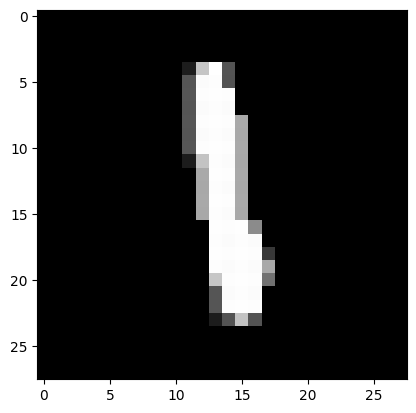

In [42]:
image_index = 200 #50
plt.imshow(x_train[image_index], cmap='gray')
label = y_train[image_index]
print(f"Label: {label}")

In [43]:
# **Input Processing**
input_image = (x_train[image_index].astype(float) * 128 / 256).astype(np.int8)
print(f"Input Feature Vector:\n{input_image}")

Input Feature Vector:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  14  98 127  42   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  42 125 126  41   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  43 126 127 126   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  42 125 126 125   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 

Input Feature Vector:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  14 119  20
   0   0   0   0   0   0   0   0   0   0   0  21 126  62   0   0   0   0
   0   0   0   0   0   0   0  21 126 104   0   0   0   0   0   0   0   0
   0   0   0  14 119 104   0   0   0   0   0   0   0   0   0   0   0   0
 105 104   0   0   0   0   0   0   0   0   0   0   0   0 105 104   0   0
   0   0   0   0   0   0   0   0   0   0  63 126  48   0   0   0   0   0
   0   0   0   0   0   0  63 126  90   0   0   0   0   0   0   0   0   0
   0   0  35 126  77   0   0   0   0   0   0   0   0   0   0   0  14  98
  41   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


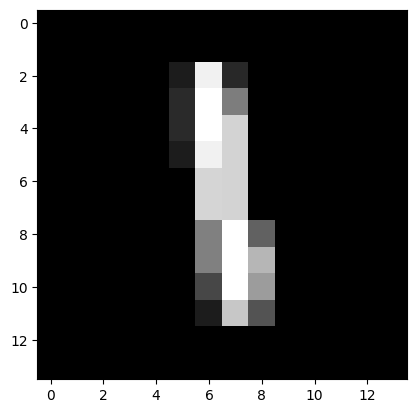

In [44]:
# Step 1: Average Pooling (28x28 → 14x14)
pooled = average_pooling(input_image)
plt.imshow(pooled, cmap='gray')

# Step 2: Flatten to 196 elements
input_feature = pooled.flatten().astype(np.int8)
print(f"Input Feature Vector:\n{input_feature}")


In [45]:
# **MLP Forward Pass**
# Hidden Layer
layer1_output = layer_forward(input_feature, weights_HL, biases_HL, verbose=True)
print(f"Hidden Layer Output:\n{layer1_output}")

# Output Layer
layer2_output = layer_forward(layer1_output, weights_OL, biases_OL, verbose=True)
print(f"Output Layer Output:\n{layer2_output}")

# Decision Block
predicted_digit = decision(layer2_output)
print(f'Predicted Digit: {predicted_digit}')

Dense out:
[ -3901   1093  12652 -15824  17194   2749   7575  21018  16200  -5915
  15908 -33645   1273  -1952  18383   -861  -5374     70  15622    587
  22639  33790  10544  10283 -38405  20328  11178  -9242  -3343  23940
  10088  15426]
Hidden Layer Output:
[    0  1093 12652     0 17194  2749  7575 21018 16200     0 15908     0
  1273     0 18383     0     0    70 15622   587 22639 33790 10544 10283
     0 20328 11178     0     0 23940 10088 15426]
Dense out:
[-5056117  2074036 -1236868  -459815 -1518830 -2264880 -2325566 -2609297
   246759 -3254669]
Output Layer Output:
[      0 2074036       0       0       0       0       0       0  246759
       0]
Predicted Digit: 1


# Accuracy test of quantized model

In [46]:
def test_accuracy(test_dataset, test_label):
  accuracy = 0
  for i in range(len(test_dataset)):
    # Scale to int8
    input = (test_dataset[i].astype(float) * 128 / 256).astype(np.int8)

    # Apply average pooling
    averaged_input = average_pooling(input)

    # Flatten input and extend to int32
    flattened_input = averaged_input.flatten().astype(np.int32)

    # Forward step
    layer1_output = layer_forward(flattened_input, weights_HL, biases_HL)
    layer2_output = layer_forward(layer1_output, weights_OL, biases_OL)
    predicted_digit = decision(layer2_output)

    # Compare with test label
    if predicted_digit == test_label[i]:
      accuracy += 1

  return accuracy / len(test_dataset)




In [47]:
quantized_accuracy = test_accuracy(x_test, y_test)
print(f"Quantized Accuracy: {quantized_accuracy}")

Quantized Accuracy: 0.9575
